# Improvements to models

We attempt to modify the model in the following ways:  

1.  Generalizing to a second order model  (first order for leaders/predators and second order for followers/prey)  

2. Adding perception cones of individuals 

3. Change the area of effect of other individuals: the interaction force is no longer averaged over the entire population but over $k$ nearest neighbours

## 1 A second order model  

The following is a second order model  

$$
\begin{equation}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2}} \\[5ex]
        \dot{z} = w\\[2ex]
        \dot{w} = \dfrac{1}{N} \sum\limits_{k=1}^N  \dfrac{\kappa_p(v_k-w)}{(\zeta_p ^2 + \|z-x_k\|^2)^{\gamma_p}} + c\dfrac{x_k-z}{\|x_k-z\|^p}
    \end{cases}
\end{equation}
$$  

For the moment $\kappa=\zeta=\gamma=1$ for both the prey and predator, while the parameters $a,b_1, b_2, c, p$ can be tuned.  
It might be better if the summation above was taken to exclude the $j^{th}$ prey.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from solvers.rk_solvers import *
from solvers.euler import *
from helper import *

In [2]:
def model1(y, params):
  '''
  Returns ndarray of shape (dim, 2) containing the derivatives.   
  
  Input:   
    - y: an array containing the following inputs   
      - pprey: ndarray of (N,2), the positions of the prey  
      - vprey: ndarray of (N,2), the velocities of the prey  
      - ppred: ndarray of (1,2), the positions of the predator  
      - vpred: ndarray of (1,2), the velocities of the predator  

    - params: extra parameters for the model (N, a, b1, b2, c, p) for now

  Returns:   
    - dy: ndarray of (2*N+2, 2), the derivatives of the inputs  
  '''  

  # unpacking parameters
  N, a, b1, b2, c, p = params 

  pprey = y[0:N]  
  vprey = y[N:2*N]  
  ppred = y[2*N:2*N+1]
  vpred = y[2*N+1:]  


  # List of len N, ndarrays of shape (N-1, 2)
  dist_prey =  np.array([pprey[i] - np.delete(pprey, i, axis = 0) for i in range(N)])  

  vel_prey  =  np.array([vprey[i] - np.delete(vprey, i, axis = 0) for i in range(N)])

  # kernel of prey
  ker_prey = np.sum (-1 * vel_prey / (1 + (np.linalg.norm(dist_prey, axis = 2)[:,:,np.newaxis]**2))
                    ,axis = 1)   
  
  # attraction of prey
  attrac_prey = -1 * a * np.sum(dist_prey, axis = 1)  

  # repulsion of prey
  rep_prey = b1 * np.sum (dist_prey / (np.linalg.norm(dist_prey, axis = 2)[:,:,np.newaxis]**2),
                          axis = 1)
  
  # repulsion of predator
  rep_pred = b2 * (pprey - ppred) / (np.linalg.norm(pprey - ppred, axis = 1)[:,np.newaxis]**2)  

  # acceleration of prey
  acc_prey = (1/N) * (ker_prey + attrac_prey + rep_prey) + rep_pred  

  # kernel of predator
  ker_pred = np.sum((vprey - vpred) / (1 + np.linalg.norm(ppred - pprey, axis = 1)[:,np.newaxis]**2),
                    axis = 0)

  # acceleration of predator
  acc_pred = (1/N) * (ker_pred + 
                      c * np.sum((pprey - ppred) / (np.linalg.norm(pprey - ppred, axis = 1)[:,np.newaxis]**p), 
                                 axis = 0))[np.newaxis]
                                 
  return np.concatenate((vprey, acc_prey, vpred, acc_pred))
  

In [3]:
# Testing implementation  
N=5000  

model1(np.concatenate((np.random.rand(N,2), 
                      np.random.rand(N,2),
                      np.random.rand(1,2),
                       np.random.rand(1,2))
                                      ), params = (N,1,2,3,4,3))

array([[ 6.33486715e-01,  1.29529974e-01],
       [ 7.93376349e-01,  6.50707094e-01],
       [ 8.19970142e-03,  4.31802716e-01],
       ...,
       [-1.02327325e+01, -4.96626888e+00],
       [ 2.53305878e-01,  3.41304149e-01],
       [-2.69095288e+01, -1.02079305e+02]])

### 1.1 Testing

A dodgy case occurs probably due to numerical instability

In [9]:
N = 100
ring_test = expInit(N = N, 
                    style = 'ring',
                    second_order = True,
                    seed = 0)  

In [10]:
test_result = rk4(model1, ring_test, 0.1, 2*N+2, (0,100), 
    (N, 1, 1, 0.2, 0.9, 3))

No. of time steps: 1000


100%|██████████| 999/999 [00:09<00:00, 100.32it/s]


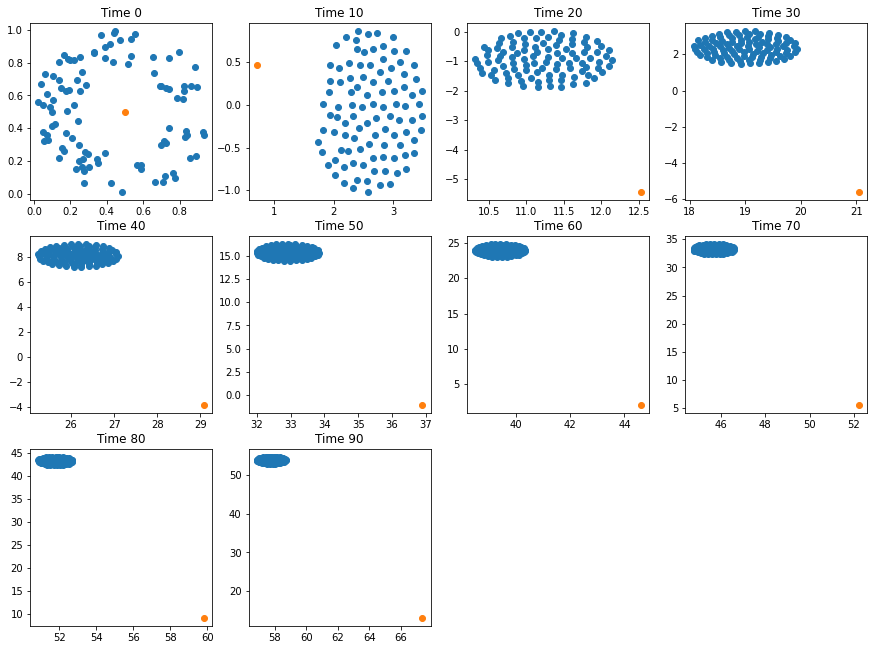

In [12]:
case = (test_result, 0.1, [i*10 for i in range(10)], 15, N)
multiPlot(case)

## 2 Adding the perception cones  

This is the same model but each individual of the prey can only react to the changes within their perceptioin cones.  

$$
\begin{equation}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \psi_\alpha(x_j,x_k,v_j) \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2}} \\[5ex]
        \dot{z} = w\\[2ex]
        \dot{w} = \dfrac{1}{N} \sum\limits_{k=1}^N  \dfrac{\kappa_p(v_k-w)}{(\zeta_p ^2 + \|z-x_k\|^2)^{\gamma_p}} + c\dfrac{x_k-z}{\|x_k-z\|^p}
    \end{cases}
\end{equation}
$$  

## 3 Adding topological effect  

Finally we consider the nearest neighbours' effect on each prey.